# Classificazione dell'abitabilità degli exoplanets


Confronto tra diversi *modelli di apprendimento supervisionato* per la classificazione di esopianeti scoperti durante le diverse missioni spaziali.

L'obbiettivo è sicuramente quello di trovare il migliore modello di classifficazione in grado di deteminare la classe si abitibilità dell'esopianeta sottoposto al modello, sebbene i dati a nostra disposizione non sono sicuramente dei migliori.

Questo sistema inoltre si pone come modulo complementare del sistema più ampio progettato per l'esame di ingeneria della conoscenza, il quale permetterà di agire un sistema esperto.

I modelli valutati in questo modulo sono i seguenti:
- **Decision**
- **Naive Bayes**
- **Random Forest**
- **Gradiend Boost**
- **Support vector machine**

## Analisi Esplorativa & Preparazione dei Dati

Importo i moduli e le librerie di interesse, utili per la realizzazione del sistema.

In [34]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from imblearn.metrics import geometric_mean_score


Carichiamo il dataset in locale.

In [35]:
planets = pd.read_csv("../PHL-EC.csv")
planets.head()

,P. Name,P. Name Kepler,P. Name KOI,P. Zone Class,P. Mass Class,P. Composition Class,P. Atmosphere Class,P. Habitable Class,P. Min Mass (EU),P. Mass (EU),P. Max Mass (EU),P. Radius (EU),P. Density (EU),P. Gravity (EU),P. Esc Vel (EU),P. SFlux Min (EU),P. SFlux Mean (EU),P. SFlux Max (EU),P. Teq Min (K),P. Teq Mean (K),P. Teq Max (K),P. Ts Min (K),P. Ts Mean (K),P. Ts Max (K),P. Surf Press (EU),P. Mag,P. Appar Size (deg),P. Period (days),P. Sem Major Axis (AU),P. Eccentricity,P. Mean Distance (AU),P. Inclination (deg),P. Omega (deg),S. Name,S. Name HD,S. Name HIP,S. Constellation,S. Type,S. Mass (SU),S. Radius (SU),S. Teff (K),S. Luminosity (SU),S. [Fe/H],S. Age (Gyrs),S. Appar Mag,S. Distance (pc),S. RA (hrs),S. DEC (deg),S. Mag from Planet,S. Size from Planet (deg),S. No. Planets,S. No. Planets HZ,S. Hab Zone Min (AU),S. Hab Zone Max (AU),P. HZD,P. HZC,P. HZA,P. HZI,P. SPH,P. Int ESI,P. Surf ESI,P. ESI,S. HabCat,P. Habitable,P. Hab Moon,P. Confirmed,P. Disc. Method,P. Disc. Year,Unnamed: 68
0,1RXS 1609 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,NaN,4451.16,NaN,19.04,0.64,12.28,15.29,4.08E-06,4.08E-06,4.08E-06,11.4,11.4,11.4,NaN,NaN,NaN,2870.4,-10.06,36.81,NaN,330.0,0.0,330.0,NaN,0.0,1RXS1609,NaN,NaN,Sco,K7V,0.73,1.35,4060.0,0.444285,NaN,0.011,NaN,145.0,16.1583,-21.0828,-13.2,0.0022,1,0,0.540,1.362,800.07,23.51,85.62,0.00,NaN,0,0,0.05,0,0,0,1,Imaging,2008,NaN
1,1SWASP J1407 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,6358.80,6358.80,NaN,10.94,4.86,53.12,24.11,0.02166914,0.02166914,0.02166914,97.7,97.7,97.7,NaN,NaN,NaN,30873.8,-18.21,20.91,3725.0,3.9,0.0,3.9,NaN,0.0,1SWASP J1407,NaN,NaN,Cen,K,0.90,0.99,4400.0,0.329588,NaN,0.016,12.4,133.0,14.1300,-39.7619,-22.5,0.1353,1,0,0.461,1.143,9.07,15.30,45.41,0.02,NaN,0,0,0.07,0,0,0,1,Primary Transit,2012,NaN
2,2M 0103-55(AB) b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,4133.22,4133.22,NaN,11.40,2.79,31.79,19.04,3.96E-06,3.96E-06,3.96E-06,11.4,11.4,11.4,NaN,NaN,NaN,11520.8,-8.91,21.80,NaN,84.0,0.0,84.0,NaN,0.0,2M 0103-55(AB),NaN,NaN,Phe,M,0.40,0.38,3840.0,0.027955,NaN,0.030,NaN,47.2,1.0600,-55.2656,-13.2,0.0024,1,0,0.136,0.347,793.67,12.57,107.44,0.00,NaN,0,0,0.06,0,0,0,1,Imaging,2013,NaN
3,2M 0122-24 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,NaN,6358.80,NaN,11.20,4.53,50.69,23.83,1.03E-05,1.03E-05,1.03E-05,14.4,14.4,14.4,NaN,NaN,NaN,28780.4,-9.92,21.41,NaN,52.0,0.0,52.0,NaN,0.0,2M 0122-24,NaN,NaN,Cet,M3.5,0.40,0.38,3840.0,0.027955,NaN,0.120,NaN,36.0,1.3808,-24.6142,-14.2,0.0039,1,0,0.136,0.347,490.45,15.72,119.46,0.00,NaN,0,0,0.08,0,0,0,1,Imaging,2013,NaN
4,2M 0219-39 b,NaN,NaN,Cold,Jovian,gas,hydrogen-rich,non-habitable,NaN,4419.37,NaN,16.13,1.05,16.99,16.55,2.37E-07,2.37E-07,2.37E-07,5.6,5.6,5.6,NaN,NaN,NaN,4655.6,-6.60,31.03,NaN,156.0,0.0,156.0,NaN,0.0,2M 0219-39,NaN,NaN,For,M6,0.11,0.27,3064.0,0.005765,NaN,NaN,NaN,39.4,2.3228,-39.4231,-10.1,0.0009,1,0,0.062,0.165,3028.82,19.46,133.25,0.00,NaN,0,0,0.06,0,0,0,1,Imaging,2015,NaN


### Pulizia dei dati

Verichiamo quanti esempi sono presenti per ogni classe di abitibilità.


In [36]:
# mi faccio una idea idea su quali siano le tipologie di pianeti con meno esempi

target_count = planets['P. Habitable Class'].value_counts()
target_count

non-habitable        3820
mesoplanet             31
psychroplanet          18
hypopsychroplanet       3
thermoplanet            3
Name: P. Habitable Class, dtype: int64

Eliminiamo le tipologie di pianeti per i quali abbiamo pochi esempi.

In [37]:
# elimino effettivamente i pianeti appartenenyi alla classe dei 'thermoplanet' e 'hypopsychroplanet'
# per i quali abbiamo solamente 3 esempi ciscuno

indexNames = planets[planets['P. Habitable Class'] == 'thermoplanet'].index
planets.drop(indexNames, inplace= True)


indexNames = planets[planets['P. Habitable Class'] == 'hypopsychroplanet'].index
planets.drop(indexNames, inplace= True)

Dopo l'eliminazione delle classi con pochi esempi avrà la seguente situazione; le classi di abitabilità non saranno più 5 ma saranno ridotte a 3 classi di abitabilita:
+ **non-habitable**
+ **mesoplanet**
+ **psychroplanet**

In [38]:
# ora la situazione sarà la seguente

target_count = planets['P. Habitable Class'].value_counts()
target_count

non-habitable    3820
mesoplanet         31
psychroplanet      18
Name: P. Habitable Class, dtype: int64

Avendo eliminato degli esempi, ossia delle righe dal nostro dataframe devo resettare di conseguenza l'index.

In [39]:
# resetto l'index del nostro database che è cambiato avendo tolto alcuni esempi

planets.reset_index(inplace = True, drop= True)

Continuamo rimuovendo ulteriori features in input, in modo tale da ridurre la dimensionalità del feautures space e in modo tale da rimuovere quelle features per le quali si hanno pochi dati.

In [40]:
# funzione che permette di rimuovere le feutures la cui densità è sotto un certo treshold
# count = valori nulli in una colonna specifica(in una feature)
# lenplanet(planet) = numero di righe totali(tot pianeti)
# count/len(planet) = ci dice in percentuale quanti valori ci saranno in quella colonna

def remove_missing(feauture):
    count = len(planets[planets[feauture].isnull()])
    if count/len(planets) > 0.2:
        return 1
    else:
        return 0
    
missing_values = [x for x in planets.columns if remove_missing(x)]
planets = planets.drop(missing_values, axis=1)

Rimuoviamo anche le seguenti features che non hanno alcuna valenza per il nostro obbiettivo, rappresentando alcune di esse l'incertezza di alcune features, e altre non hanno valenza da un punto di vista fisico.

In [41]:
# rimuovo altre features che rappresentano l'incertezza di alcune feautures e
# altre feautures che non interessano direttamente la classificazione

cols_to_drop = ['P. Name','S. Constellation', 'S. Type', 'P. Int ESI', 
                'P. Surf ESI', 'P. Disc. Method', 'P. Disc. Year','P. Hab Moon', 'P. SFlux Min (EU)', 'P. SFlux Max (EU)',
                'P. Teq Min (K)','P. Teq Max (K)','P. SFlux Mean (EU)','S. Name', 'S. Hab Zone Min (AU)', 'S. Hab Zone Max (AU)']

# TODO decidere se eliminare altre features tipo HZC ecc

planets = planets.drop(cols_to_drop, axis=1)

Le features rimaste per il momento saranno pertanto le seguenti.

In [42]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

print(planets.columns.tolist())


['P. Zone Class', 'P. Mass Class', 'P. Composition Class', 'P. Atmosphere Class', 'P. Habitable Class', 'P. Mass (EU)', 'P. Radius (EU)', 'P. Density (EU)', 'P. Gravity (EU)', 'P. Esc Vel (EU)', 'P. Teq Mean (K)', 'P. Surf Press (EU)', 'P. Mag', 'P. Appar Size (deg)', 'P. Period (days)', 'P. Sem Major Axis (AU)', 'P. Eccentricity', 'P. Mean Distance (AU)', 'P. Omega (deg)', 'S. Mass (SU)', 'S. Radius (SU)', 'S. Teff (K)', 'S. Luminosity (SU)', 'S. RA (hrs)', 'S. DEC (deg)', 'S. Mag from Planet', 'S. Size from Planet (deg)', 'S. No. Planets', 'S. No. Planets HZ', 'P. HZD', 'P. HZC', 'P. HZA', 'P. HZI', 'P. ESI', 'S. HabCat', 'P. Habitable', 'P. Confirmed']


Per decidere se eliminare altre features osserviamo la correlazione tra le feutures creando una visualizzazione che traccia la misura di correlazione per ogni feature nel set di dati.

Prima di poter fare questo però devo :
1. *riempire il dataset con dati mancanti*
2. *trasformare le feauture categoriche in feauturs numeriche*


Prima di tutto determiniamoo quali siano le features categoriche

In [43]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
print(planets.dtypes.tolist)

<bound method IndexOpsMixin.tolist of P. Zone Class                 object
P. Mass Class                 object
P. Composition Class          object
P. Atmosphere Class           object
P. Habitable Class            object
P. Mass (EU)                 float64
P. Radius (EU)               float64
P. Density (EU)              float64
P. Gravity (EU)              float64
P. Esc Vel (EU)              float64
P. Teq Mean (K)              float64
P. Surf Press (EU)           float64
P. Mag                       float64
P. Appar Size (deg)          float64
P. Period (days)             float64
P. Sem Major Axis (AU)       float64
P. Eccentricity              float64
P. Mean Distance (AU)        float64
P. Omega (deg)               float64
S. Mass (SU)                 float64
S. Radius (SU)               float64
S. Teff (K)                  float64
S. Luminosity (SU)           float64
S. RA (hrs)                  float64
S. DEC (deg)                 float64
S. Mag from Planet           float64


Si noti come le uniche features categoriche siano le prime 5:

1. *P. Zone Class*
2. *P. Mass Class*
3. *P. Composition Class*
4. *P. Atmosphere Class*
5. *P. Habitable Class'*


Verifichiamo quanti siano i dati mancanti in totale, considerando quindi sia le features categoriche che quelle numeriche.
Sfruttiamo inoltre un heatmap per facilitare la lettura di tali valori.


P. Zone Class                 46
P. Mass Class                  6
P. Composition Class          41
P. Atmosphere Class           85
P. Habitable Class             0
P. Mass (EU)                  33
P. Radius (EU)                12
P. Density (EU)               41
P. Gravity (EU)               41
P. Esc Vel (EU)               41
P. Teq Mean (K)               46
P. Surf Press (EU)            41
P. Mag                        56
P. Appar Size (deg)           12
P. Period (days)             150
P. Sem Major Axis (AU)        35
P. Eccentricity                0
P. Mean Distance (AU)         35
P. Omega (deg)                 0
S. Mass (SU)                  47
S. Radius (SU)               112
S. Teff (K)                   99
S. Luminosity (SU)            28
S. RA (hrs)                    0
S. DEC (deg)                   0
S. Mag from Planet            46
S. Size from Planet (deg)    128
S. No. Planets                 0
S. No. Planets HZ              0
P. HZD                        46
P. HZC    

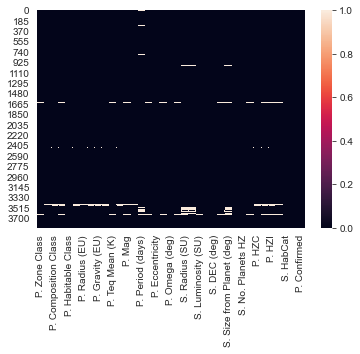

In [44]:
print(planets.isnull().sum())
sns.heatmap(planets.isnull())

##### FASE 1 : riempire il dataset con dati mancanti

Per le features numeriche adottiamo il** simple Imputer di sklearn** che permette di riempire il valore mancante con il valore medio all'interno della colonna, specificando come strategia *mean*

In [45]:
# inserisco le features numeriche in una lista
numeric_features = list(planets[planets._get_numeric_data().columns])

simple_inputer = SimpleImputer(missing_values=np.nan, strategy='mean')
planets[numeric_features] = simple_inputer.fit_transform(planets[numeric_features])

planets[numeric_features].isnull().sum()

P. Mass (EU)                 0
P. Radius (EU)               0
P. Density (EU)              0
P. Gravity (EU)              0
P. Esc Vel (EU)              0
P. Teq Mean (K)              0
P. Surf Press (EU)           0
P. Mag                       0
P. Appar Size (deg)          0
P. Period (days)             0
P. Sem Major Axis (AU)       0
P. Eccentricity              0
P. Mean Distance (AU)        0
P. Omega (deg)               0
S. Mass (SU)                 0
S. Radius (SU)               0
S. Teff (K)                  0
S. Luminosity (SU)           0
S. RA (hrs)                  0
S. DEC (deg)                 0
S. Mag from Planet           0
S. Size from Planet (deg)    0
S. No. Planets               0
S. No. Planets HZ            0
P. HZD                       0
P. HZC                       0
P. HZA                       0
P. HZI                       0
P. ESI                       0
S. HabCat                    0
P. Habitable                 0
P. Confirmed                 0
dtype: i

Per le features categoriche adottiamo il **simple Imputer di sklearn** che permette di riempire il valore mancante con quello più ricorrente all'interno della colonna, specificando come strategia *most frequent*

In [46]:
# inserisco le features categoriche in una lista
categorical_features = [col for col in planets.columns if planets[col].dtype=="O"]

simple_inputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
planets[categorical_features] = simple_inputer.fit_transform(planets[categorical_features])

planets[categorical_features].isnull().sum()


P. Zone Class           0
P. Mass Class           0
P. Composition Class    0
P. Atmosphere Class     0
P. Habitable Class      0
dtype: int64

Il risultato finale sarà il seguente.


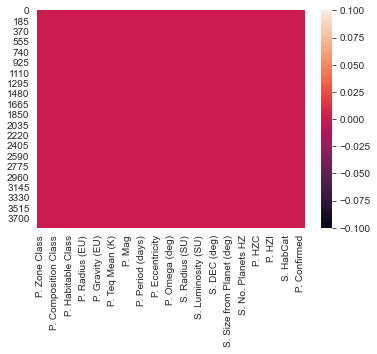

In [47]:
sns.heatmap(planets.isnull())

##### FASE 2 : trasformare le feauture categoriche in feauturs numeriche

Le prime 3 features (*P. Zone Class, P. Mass Class, new P. Habitable Class*) verranno trasformate utilizzando il **label encoding**, essendoci effettivamente un ordine tra i values le features. 

In [48]:
ord_enc = OrdinalEncoder()
planets["new P. Zone Class_code"] = ord_enc.fit_transform(planets[["P. Zone Class"]])

planets["new P. Mass Class"] = ord_enc.fit_transform(planets[["P. Mass Class"]])

planets["new P. Habitable Class"] = ord_enc.fit_transform(planets[["P. Habitable Class"]])



N.B 
Poichè si è scoperto che stratifiedKFold non funziona con le feututres target multilabel ossia con le variabili indicatrici
si è deciso di optare per il label encoding sebbene questa non sia stata la prima scelta
Errore uscito : 'Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead'
Link stackOverflow : https://stackoverflow.com/questions/54890899/not-able-to-use-stratified-k-fold-on-multi-label-classifier.
Scrivere la risposta del link nella doc.

Le altre tre features (*P. Composition Class, P. Atmosphere Class)* verranno traformate utilizzando **l'hot encoder** che crea nuove feutures booleane a partire dai values delle feautures, ossia crea le *variabili indicatrici*


In [49]:
# Il punto chiave è che devi utilizzare toarray() per convertire i risultati in un 
# formato che può essere convertito in un DataFrame.

# traformazione feature P. Composition Class
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(planets[["P. Composition Class"]])
pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)

# Il passaggio successivo è unire questi dati al dataframe originale.
planets = planets.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

# traformazione feature P. Atmosphere Class
oe_results = oe_style.fit_transform(planets[["P. Atmosphere Class"]])
pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)

planets = planets.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))


# NON FUNZIONA LEGGERE SOPRA(blocco markdown sotto il blocco 67)
#  traformazione feature P. Habitable Class
#oe_results = oe_style.fit_transform(planets[["P. Habitable Class"]])
#pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)

#planets = planets.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

Il dataframe con le nuove features sarà il seguente

In [50]:
planets.head()

,P. Zone Class,P. Mass Class,P. Composition Class,P. Atmosphere Class,P. Habitable Class,P. Mass (EU),P. Radius (EU),P. Density (EU),P. Gravity (EU),P. Esc Vel (EU),P. Teq Mean (K),P. Surf Press (EU),P. Mag,P. Appar Size (deg),P. Period (days),P. Sem Major Axis (AU),P. Eccentricity,P. Mean Distance (AU),P. Omega (deg),S. Mass (SU),S. Radius (SU),S. Teff (K),S. Luminosity (SU),S. RA (hrs),S. DEC (deg),S. Mag from Planet,S. Size from Planet (deg),S. No. Planets,S. No. Planets HZ,P. HZD,P. HZC,P. HZA,P. HZI,P. ESI,S. HabCat,P. Habitable,P. Confirmed,new P. Zone Class_code,new P. Mass Class,new P. Habitable Class,"(gas,)","(iron,)","(rocky-iron,)","(rocky-water,)","(water-gas,)","(hydrogen-rich,)","(metals-rich,)","(no-atmosphere,)"
0,Cold,Jovian,gas,hydrogen-rich,non-habitable,4451.16,19.04,0.64,12.28,15.29,11.4,2870.4,-10.06,36.81,721.574617,330.0,0.0,330.0,0.0,0.73,1.35,4060.0,0.444285,16.1583,-21.0828,-13.2,0.0022,1.0,0.0,800.07,23.51,85.62,0.00,0.05,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Cold,Jovian,gas,hydrogen-rich,non-habitable,6358.80,10.94,4.86,53.12,24.11,97.7,30873.8,-18.21,20.91,3725.000000,3.9,0.0,3.9,0.0,0.90,0.99,4400.0,0.329588,14.1300,-39.7619,-22.5,0.1353,1.0,0.0,9.07,15.30,45.41,0.02,0.07,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Cold,Jovian,gas,hydrogen-rich,non-habitable,4133.22,11.40,2.79,31.79,19.04,11.4,11520.8,-8.91,21.80,721.574617,84.0,0.0,84.0,0.0,0.40,0.38,3840.0,0.027955,1.0600,-55.2656,-13.2,0.0024,1.0,0.0,793.67,12.57,107.44,0.00,0.06,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Cold,Jovian,gas,hydrogen-rich,non-habitable,6358.80,11.20,4.53,50.69,23.83,14.4,28780.4,-9.92,21.41,721.574617,52.0,0.0,52.0,0.0,0.40,0.38,3840.0,0.027955,1.3808,-24.6142,-14.2,0.0039,1.0,0.0,490.45,15.72,119.46,0.00,0.08,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Cold,Jovian,gas,hydrogen-rich,non-habitable,4419.37,16.13,1.05,16.99,16.55,5.6,4655.6,-6.60,31.03,721.574617,156.0,0.0,156.0,0.0,0.11,0.27,3064.0,0.005765,2.3228,-39.4231,-10.1,0.0009,1.0,0.0,3028.82,19.46,133.25,0.00,0.06,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Rinomiano il label delle nuove features create.


In [51]:
planets.rename({('gas',): 'Composition gas', 
                ('iron',): 'Composition iron',
                ('rocky-iron',): 'Composition rocky-iron', 
                ('rocky-water',): 'Composition rocky-water',
                ('water-gas',): 'Composition water-gas'}, axis=1, inplace= True) 

planets.rename({('hydrogen-rich',): 'Atmosphere hydrogen-rich', 
                ('metals-rich',): 'Atmosphere metals-rich',
                ('no-atmosphere',): 'Atmosphere no-atmosphere'}, axis=1, inplace= True) 

# NON FUNZIONA LEGGERE SOPRA(blocco markdown sotto il blocco 67)
#planets.rename({('mesoplanet',): 'Habitable mesoplanet', 
                # ('non-habitable',): 'Habitable non-habitable',
                # ('psychroplanet',): 'Habitable psychroplanet'}, axis=1, inplace= True) 


Osserviamo la correlazione

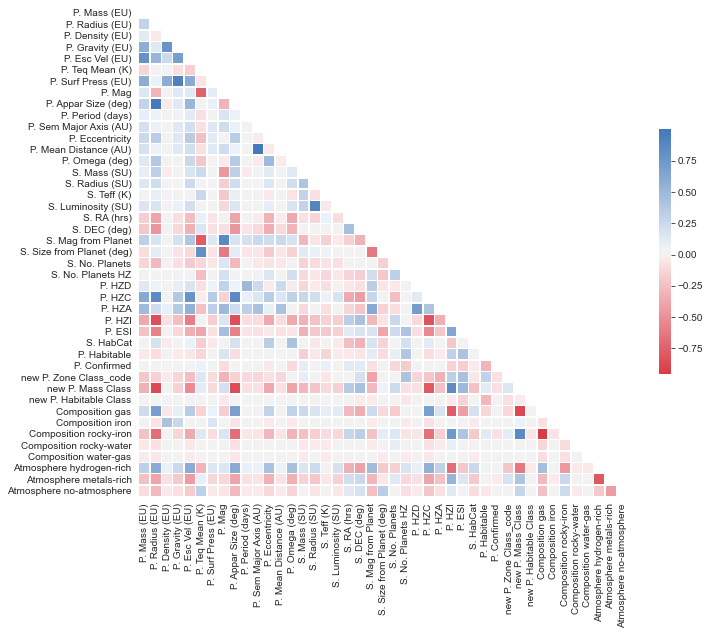

In [52]:
# pands .corr() per calcolare la correlazione a coppie tra le features del dataframes
corr = planets.corr()

# visualizzo i dati con seaborn
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

Si noti come tra le features rimaste ci siano delle feautures altamente correlate tra di loro, che restituiscono sostanzialmente le stesse informazioni, pertanto le rimuoviamo:

- **P. Mass Class ---> P. Radius (EU) and P. Mass (EU)**
- **P. Zone Class ---> HZD**


In [53]:
cols_to_drop = ["P. Mass Class", "P. Zone Class"]

planets = planets.drop(cols_to_drop, axis=1)

Possiamo ora notare comee il nostro dataset sia molto sbilanciato

non-habitable: 3820
mesoplanet: 31
psychroplanet : 18
Percentage of Majority Class: 98.72999999999999
Percentage of Minority Class: 0.8
Percentage of Minority Class: 0.47000000000000003


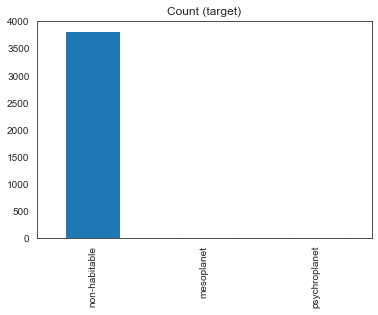

In [54]:
target_count = planets['P. Habitable Class'].value_counts()
print(f'non-habitable: {target_count[0]}')
print(f'mesoplanet: {target_count[1]}')
print(f'psychroplanet : {target_count[2]}')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')
print(f'Percentage of Minority Class: {round(target_count[1] / sum(target_count), 4)*100}')
print(f'Percentage of Minority Class: {round(target_count[2] / sum(target_count), 4)*100}')

target_count.plot(kind='bar', title='Count (target)')

In [55]:
planets.head()

,P. Composition Class,P. Atmosphere Class,P. Habitable Class,P. Mass (EU),P. Radius (EU),P. Density (EU),P. Gravity (EU),P. Esc Vel (EU),P. Teq Mean (K),P. Surf Press (EU),P. Mag,P. Appar Size (deg),P. Period (days),P. Sem Major Axis (AU),P. Eccentricity,P. Mean Distance (AU),P. Omega (deg),S. Mass (SU),S. Radius (SU),S. Teff (K),S. Luminosity (SU),S. RA (hrs),S. DEC (deg),S. Mag from Planet,S. Size from Planet (deg),S. No. Planets,S. No. Planets HZ,P. HZD,P. HZC,P. HZA,P. HZI,P. ESI,S. HabCat,P. Habitable,P. Confirmed,new P. Zone Class_code,new P. Mass Class,new P. Habitable Class,Composition gas,Composition iron,Composition rocky-iron,Composition rocky-water,Composition water-gas,Atmosphere hydrogen-rich,Atmosphere metals-rich,Atmosphere no-atmosphere
0,gas,hydrogen-rich,non-habitable,4451.16,19.04,0.64,12.28,15.29,11.4,2870.4,-10.06,36.81,721.574617,330.0,0.0,330.0,0.0,0.73,1.35,4060.0,0.444285,16.1583,-21.0828,-13.2,0.0022,1.0,0.0,800.07,23.51,85.62,0.00,0.05,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,gas,hydrogen-rich,non-habitable,6358.80,10.94,4.86,53.12,24.11,97.7,30873.8,-18.21,20.91,3725.000000,3.9,0.0,3.9,0.0,0.90,0.99,4400.0,0.329588,14.1300,-39.7619,-22.5,0.1353,1.0,0.0,9.07,15.30,45.41,0.02,0.07,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,gas,hydrogen-rich,non-habitable,4133.22,11.40,2.79,31.79,19.04,11.4,11520.8,-8.91,21.80,721.574617,84.0,0.0,84.0,0.0,0.40,0.38,3840.0,0.027955,1.0600,-55.2656,-13.2,0.0024,1.0,0.0,793.67,12.57,107.44,0.00,0.06,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,gas,hydrogen-rich,non-habitable,6358.80,11.20,4.53,50.69,23.83,14.4,28780.4,-9.92,21.41,721.574617,52.0,0.0,52.0,0.0,0.40,0.38,3840.0,0.027955,1.3808,-24.6142,-14.2,0.0039,1.0,0.0,490.45,15.72,119.46,0.00,0.08,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,gas,hydrogen-rich,non-habitable,4419.37,16.13,1.05,16.99,16.55,5.6,4655.6,-6.60,31.03,721.574617,156.0,0.0,156.0,0.0,0.11,0.27,3064.0,0.005765,2.3228,-39.4231,-10.1,0.0009,1.0,0.0,3028.82,19.46,133.25,0.00,0.06,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


N.B 
Poichè si è scoperto che stratifiedKFold non funziona con le feututres target multilabel ossia con le variabili indicatrici
si è deciso di optare per il label encoding sebbene questa non sia stata la prima scelta
Errore uscito : 'Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead'
Link stackOverflow : https://stackoverflow.com/questions/54890899/not-able-to-use-stratified-k-fold-on-multi-label-classifier



Divido il dataset

In [56]:
# TODO fare una copia forse
cols_to_drop = ["P. Composition Class", "P. Atmosphere Class","P. Habitable Class"]

planets = planets.drop(cols_to_drop, axis=1)

In [57]:
target_features = ['new P. Habitable Class']

# X: set di samples con le input features
# y: set di samples con la target feature

X = planets.drop(target_features, axis=1)
y = planets[target_features]



In [58]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=11)


## Costruzione dei modelli & Addestramento

### Classificazione con  DecisionTreeClassifier

In [60]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', DecisionTreeClassifier(random_state=11)]])

si è deciso di usare lo StratifiedKFold in modo tale da mantenere le proporzioni avendo un dataset molto sbilanciato

In [61]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

In [62]:

# in param_grid sono definiti gli iperparametri
# TODO definire iper parametri per ogni metodo di classificazione
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(1,10),
    'min_samples_split':range(2,10),
    'min_samples_leaf':range(1,5)    
}
new_params = {'classifier__' + key: param_grid[key] for key in param_grid}


# permette di provare tutte le combinazioni degli iper parametri in modo tale da ottenre 
# i valori ottimali per il modello
# quindi itera per ogni fold creata sugli iperparametri 
# Niper = numero iper paratri                   
# Nfold = numero fold
# Viper = values per ogni per parametro
# complessita credo = ((Nfold)^Viper)^Niper

# TODO verificare per quale motivo non funzionano le altre metriche
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [63]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')
# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)


Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Cross-validation score: 0.9990306944663745


accuracy: 0.9987080103359173
precision: 0.9523809523809524
recall: 0.9166666666666666
f1: 0.9267399267399267
matthews_corrcoef: 0.9495595614242498
geometric_mean_score: 0.9572193102264341


[]

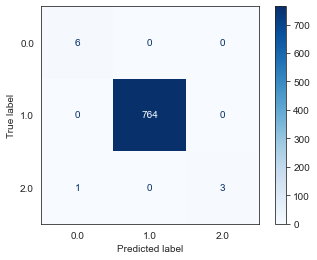

In [64]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
# auc = roc_auc_score(y_test, y_test_predict, multi_class = 'ovr',average='macro')
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.inferno)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
#print(f'f1: {auc}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()



In [65]:
scoring_list = []
scoring_list.append(dict([
    ('Model', 'DecisionTreeClassifier'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

### Classificazione con  Naive Bayes

non ci sono iperparametri quindi è inutile fare grid search
capire quindi se ha senso fare anche la cross validation

In [66]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', GaussianNB()]]) 

In [67]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

In [68]:
# in param_grid sono definiti gli iperparametri
# TODO definire iper parametri per ogni metodo di classificazione
param_grid = {}

# TODO verificare per quale motivo non funzionano le altre metriche
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [69]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train)

cv_score = grid_search.best_score_

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\cecca\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.9948320413436692
precision: 0.75
recall: 0.8324607329842931
f1: 0.7852774137177807
matthews_corrcoef: 0.8197002684542365
geometric_mean_score: 0.9116015388298121


[]

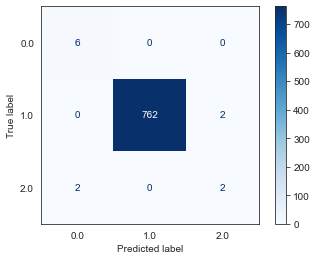

In [70]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
# auc = roc_auc_score(y_test, y_test_predict, multi_class = 'ovr',average='macro')
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.inferno)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
#print(f'f1: {auc}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [71]:
scoring_list.append(dict([
    ('Model', 'Naive Bayes'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

### Classificazione con  RandomForest

In [72]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', RandomForestClassifier(max_depth=None, random_state=None)]]) #decidete se mettere qualche parametro

In [73]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

In [74]:
# in param_grid sono definiti gli iperparametri
# TODO definire iper parametri per ogni metodo di classificazione
param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [4, 6, 10, 12],
                'random_state': [13]
                }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

# TODO verificare per quale motivo non funzionano le altre metriche
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [75]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train)

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\cecca\AppData\Roaming\Python\Python38\site-packages\imblearn\pipeline.py:272: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params_last_step)


Best parameters: {'classifier__max_depth': 4, 'classifier__n_estimators': 100, 'classifier__random_state': 13}
Cross-validation score: 0.998384699634333


accuracy: 0.9987080103359173
precision: 0.9523809523809524
recall: 0.9166666666666666
f1: 0.9267399267399267
matthews_corrcoef: 0.9495595614242498
geometric_mean_score: 0.9572193102264341


[]

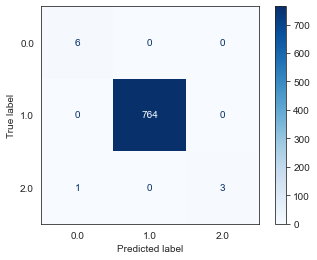

In [76]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
# auc = roc_auc_score(y_test, y_test_predict, multi_class = 'ovr',average='macro')
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.inferno)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
#print(f'f1: {auc}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [77]:
scoring_list.append(dict([
    ('Model', 'RandomForest'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

### Classificazione con Gradient Boosting

In [78]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier',GradientBoostingClassifier(n_estimators=100,
                                                                         learning_rate=1.0,
                                                                         max_depth=1, 
                                                                         random_state=11)]]) #decidete se mettere qualche parametro

In [79]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

In [80]:
# in param_grid sono definiti gli iperparametri
# TODO definire iper parametri per ogni metodo di classificazione
param_grid = {   
              'max_depth': range (2, 10, 1),
              'n_estimators': range(60, 220, 40),
              'learning_rate': [0.1, 0.01, 0.05]
              }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

# TODO verificare per quale motivo non funzionano le altre metriche
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [81]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train)

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


KeyboardInterrupt: 

In [ ]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
# auc = roc_auc_score(y_test, y_test_predict, multi_class = 'ovr',average='macro')
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.inferno)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
#print(f'f1: {auc}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [ ]:
scoring_list.append(dict([
    ('Model', 'Gradient Boosting'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

### Classificazione con SVM

In [ ]:
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier',SVC(kernel=None,
                                                  gamma=None, 
                                                  C=None)]]) #decidete se mettere qualche parametro cambiare parametri con iper parametri

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

In [ ]:
# in param_grid sono definiti gli iperparametri
# TODO definire iper parametri per ogni metodo di classificazione
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']
              }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

# TODO verificare per quale motivo non funzionano le altre metriche
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

In [ ]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train)

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

In [ ]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
# auc = roc_auc_score(y_test, y_test_predict, multi_class = 'ovr',average='macro')
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.inferno)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
#print(f'f1: {auc}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [ ]:
scoring_list.append(dict([
    ('Model', 'SVM'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

Ora confrontiamo i vari modelli secondo le metriche usate


In [82]:
results = pd.DataFrame(data=scoring_list)
results = results[['Model',
                   'Train Accuracy',
                   'Test Accuracy',
                   'Precision',
                   'Recall',
                   'F1',
                   'Matthews Corrcoef',
                   'Geometric Mean Score']]

results = results.sort_values(by='Recall', ascending=False)
results = results.set_index('Model')
results


,Train Accuracy,Test Accuracy,Precision,Recall,F1,Matthews Corrcoef,Geometric Mean Score
Model,,,,,,,
DecisionTreeClassifier,0.999,0.999,0.952,0.917,0.927,1.0,0.957
DecisionTreeClassifier,0.998,0.999,0.952,0.917,0.927,1.0,0.957
DecisionTreeClassifier,0.995,0.995,0.750,0.832,0.785,1.0,0.912
